# Counterfact Dataset
Dataset downloaded from: https://github.com/kmeng01/rome

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd

from nltk.tokenize import sent_tokenize
from tqdm import tqdm

import sys
sys.path.append("../../utils")
from dataset import preprocess_text, ireplace, dataset_stats
from wikidata import get_wikidata_entity_label, load_wikidata_json

In [2]:
with open("raw/counterfact.json", "r") as file:
    data = json.load(file)

In [3]:
data[0]

{'case_id': 0,
 'pararel_idx': 2796,
 'requested_rewrite': {'prompt': 'The mother tongue of {} is',
  'relation_id': 'P103',
  'target_new': {'str': 'English', 'id': 'Q1860'},
  'target_true': {'str': 'French', 'id': 'Q150'},
  'subject': 'Danielle Darrieux'},
 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native',
  'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'],
 'neighborhood_prompts': ['The mother tongue of Léon Blum is',
  'The native language of Montesquieu is',
  'François Bayrou, a native',
  'The native language of Raymond Barre is',
  'Michel Rocard is a native speaker of',
  'Jacques Chaban-Delmas is a native speaker of',
  'The native language of François Bayrou is',
  'Maurice Genevoix, speaker of',
  'The mother tongue of François Bayrou is',
  'Melchior de Vogüé, speaker of'],
 'attribute_prompts': ['J.\xa0R.\xa0R. Tolkien is a native speaker of',
  'The mother tongue

In [4]:
wikidata_entity_dict = load_wikidata_json("../wikidata_entity_data.json")
wikidata_relation_dict = load_wikidata_json("../wikidata_relation_data.json")

In [5]:
samples = []
for item in data:
    h = item["requested_rewrite"]["subject"]
    p_id = item["requested_rewrite"]["relation_id"]
    t = item["requested_rewrite"]["target_true"]["str"]
    t_id = item["requested_rewrite"]["target_true"]["id"]
    prompt = item["requested_rewrite"]["prompt"].format(h)
    cf_id = item["requested_rewrite"]["target_new"]["id"]
    cf_entity = wikidata_entity_dict[cf_id]["label"]
    d = {
        "full_text": prompt + " " + t + ".",
        "h": h,
        "h_id": None, # id not provided/necessary
        "r": wikidata_relation_dict[p_id]["label"],
        "r_id": p_id,
        "t": t,
        "t_id": t_id,
        "t_before_h": False,
        "prompt": prompt,
        "h_retrieved": h,
        "t_retrieved": t,
        "cf_id": cf_id,
        "cf_entity": cf_entity,
        "cf_entity_type": "t", 
        "cf_full_text": prompt + " " + cf_entity + "."
    }
    samples.append(d)
df = pd.DataFrame(samples)
df = df.reset_index(names="id") # add id to each sample

Unique relations: 34
Num samples: 21919


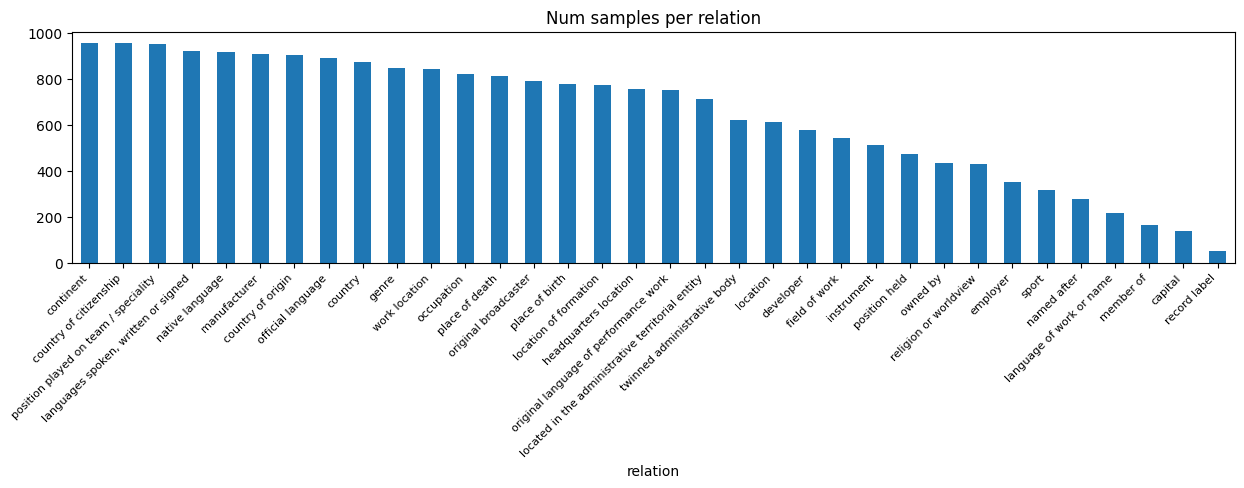

In [6]:
dataset_stats(df)

In [7]:
# preprocessing as for FewRel
print(f"Num of entities not found in wikidata: {df['cf_entity'].isna().sum()}")
# drop rows with retrieved entities which are NA

Num of entities not found in wikidata: 0


In [8]:
# full_text does not start with prompt
sum(~df.apply(lambda row: row["full_text"].startswith(row["prompt"]), axis=1))

0

In [9]:
# relevant entity appears multiple times or appears not in prompt
len(df[df.apply(lambda row: row["prompt"].lower().count(row["h"].lower()) 
                if not row["t_before_h"] else row["prompt"].lower().count(row["t"].lower()), axis=1) != 1])

0

In [10]:
# relevant entity appears multiple times or appears not in full_text without prompt
len(df[df.apply(lambda row: row["full_text"][len(row["prompt"]):].lower().count(row["t"].lower()) 
                if not row["t_before_h"] else row["full_text"][len(row["prompt"]):].lower().count(row["h"].lower()), axis=1) != 1])

0

In [11]:
# relevant for pipeline setup
# problem: some samples consist of multiple sentences or are split by sent_tokenize into multiple sentences
# we only want to generate the completion of one sentence
# removes qa style samples for counterfact e.g., What is the twin city of Lyon? It is Beirut.	
len(df[df["full_text"].apply(lambda x: len(sent_tokenize(x))) != 1])

750

In [12]:
# keep only rows with one sentence
df = df[df["full_text"].apply(lambda x: len(sent_tokenize(x))) == 1]

In [13]:
# rows where prompt has less than n words
n = 3
len(df[df["prompt"].apply(lambda x: len(x.split())) < n])

232

In [14]:
# keep rows where prompt has at least n words
df = df[df["prompt"].apply(lambda x: len(x.split())) >= n]

In [15]:
# rows where prompt has more than n words
n = 30
len(df[df["prompt"].apply(lambda x: len(x.split())) > n])

0

Unique relations: 34
Num samples: 20937


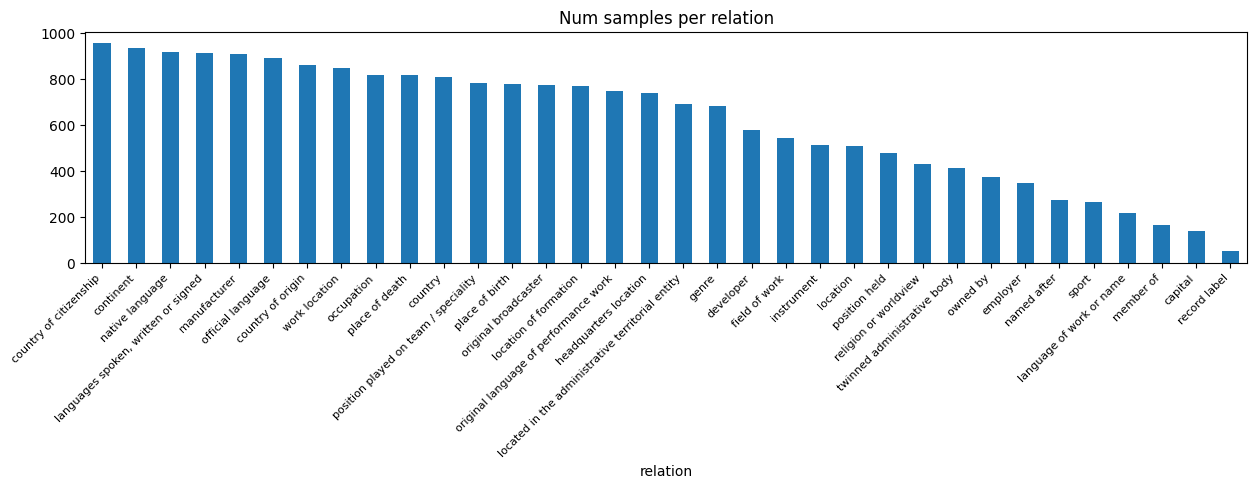

In [16]:
dataset_stats(df)

In [17]:
df.to_json("counterfact_preprocessed.json", orient="records", lines=True)

In [18]:
# sample data set for evaluation framework
# n examples per relation type
n = 53
df_val = df.groupby("r").head(n).sort_values("id")

Unique relations: 34
Num samples: 1802


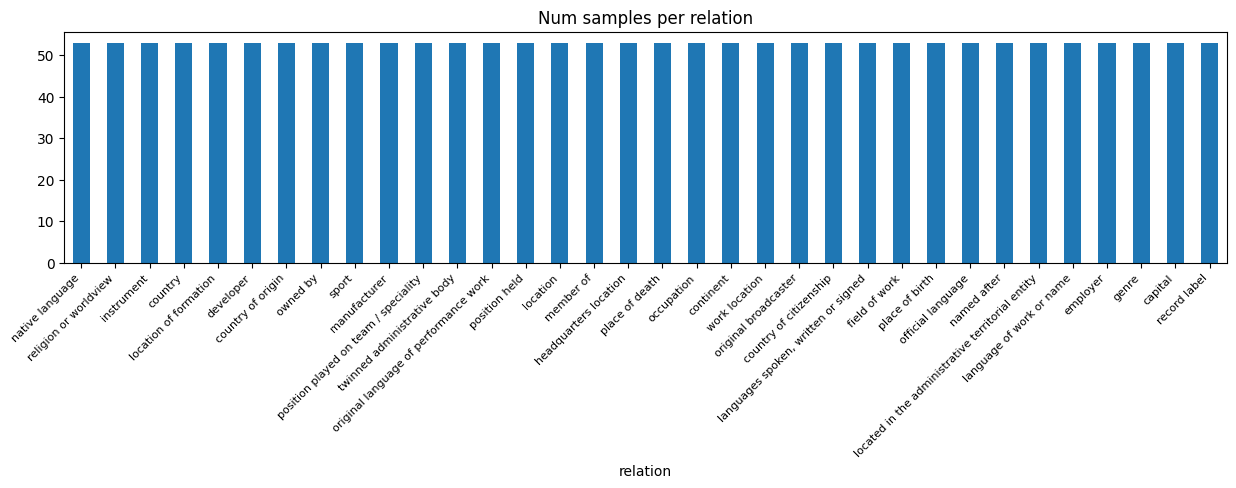

In [19]:
dataset_stats(df_val)

In [20]:
df_val.to_json("counterfact_val.json", orient="records", lines=True)

In [21]:
# dev set for developing metrics and metric eval
# n examples per relation type
n = 10
# df without df_val
df_subset = df[df["id"].apply(lambda x: x not in df_val["id"].to_list())].sort_values("id")
df_dev = df_subset.groupby("r").head(n).sort_values("id")

Unique relations: 33
Num samples: 330


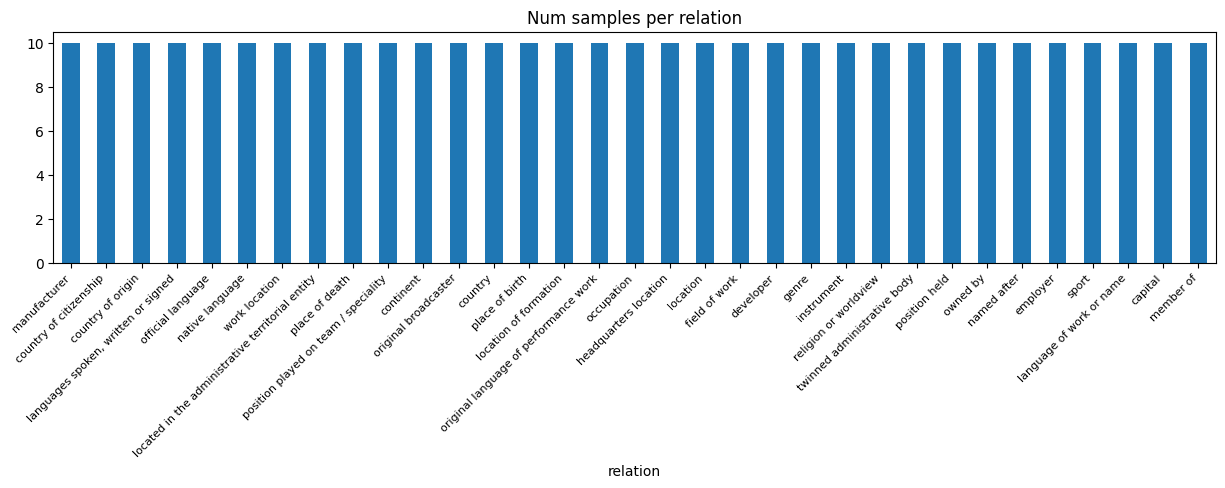

In [24]:
dataset_stats(df_dev)

In [25]:
df_dev.to_json("counterfact_dev.json", orient="records", lines=True)